In [2]:
import os
import pickle
import numpy as np
import cv2
from tools import util
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.spatial.transform import Rotation

from pathlib import Path

from utils import DLT
import math
def rotationMatrixToEulerAngles(R) :

    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])

    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

def inversePerspective(rvec, tvec):
    """ Applies perspective transform for given rvec and tvec. """
    R, _ = cv2.Rodrigues(rvec)
    R = np.matrix(R).T
    invTvec = np.dot(R, np.matrix(-tvec))
    invRvec, _ = cv2.Rodrigues(R)
    return invRvec, invTvec

def relativePosition(rvec1, tvec1, rvec2, tvec2):
    """ Get relative position for rvec2 & tvec2. Compose the returned rvec & tvec to use composeRT with rvec2 & tvec2 """
    rvec1, tvec1 = rvec1.reshape((3, 1)), tvec1.reshape((3, 1))
    rvec2, tvec2 = rvec2.reshape((3, 1)), tvec2.reshape((3, 1))

    # Inverse the second marker, the right one in the image
    invRvec, invTvec = inversePerspective(rvec2, tvec2)

    info = cv2.composeRT(rvec1, tvec1, invRvec, invTvec)
    composedRvec, composedTvec = info[0], info[1]

    composedRvec = composedRvec.reshape((3, 1))
    composedTvec = composedTvec.reshape((3, 1))
    return composedRvec, composedTvec

def write_keypoints_to_disk(filename, kpts):
    fout = open(filename, 'w')

    for frame_kpts in kpts:
        for kpt in frame_kpts:
            if len(kpt) == 2:
                fout.write(str(kpt[0]) + ' ' + str(kpt[1]) + ' ')
            else:
                fout.write(str(kpt[0]) + ' ' + str(kpt[1]) + ' ' + str(kpt[2]) + ' ')

        fout.write('\n')
    fout.close()

# os.getcwd()

In [3]:
# real = np.loadtxt('../../bodypose3d/kpts_3d.dat', usecols=[kpt_id*3, kpt_id*3+1, kpt_id*3+2])
# real.shape

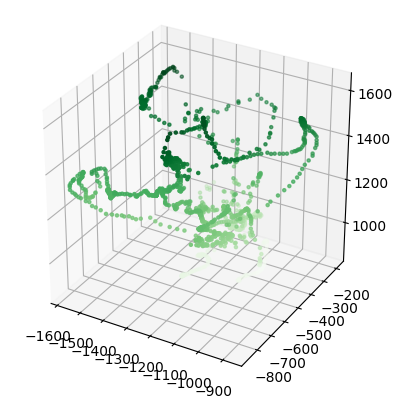

In [4]:
kpt_id = 4
real = np.loadtxt('../../bodypose3d/kpts_3d.dat', usecols=[kpt_id*3, kpt_id*3+1, kpt_id*3+2]).T
x,y,z  = real
ax = plt.axes(projection='3d')
ax.set_box_aspect((1, 1, 1))
# ax.plot3D(x, y, z, 'gray')

# Data for three-dimensional scattered points
ax.scatter3D(x, y, z, c=z, cmap='Greens', s=5)

In [5]:
real_ext = {
    'cam0':{
        'R': np.array([[0.03522596169240533, 0.9989186047045775, -0.030343908744683592],
            [-0.9954114357284269, 0.0323669499742608, -0.09004695536460891 ],
            [-0.08896743923434776, 0.03337666436934931, 0.9954751594247135 ]]),
        'T': np.array([-3.7714497419971353, 0.5952700116552851, 14.753837487029038 ])
    },
    'cam1':{
        'R': np.array([[0.01862128,  0.72598112,  0.68746248],
                    [-0.99830361, -0.02443645,  0.05284666],
                    [0.05516482, -0.68728034,  0.72429454]]),
        'T': np.array([-8.97548292, 1.56690522, 22.88471505])
    },
}

(0.12044908746700707, -0.16590770802668048)

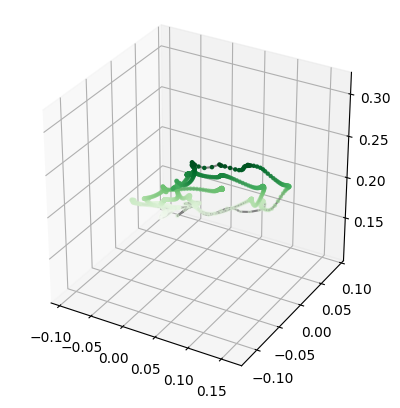

In [3]:
%matplotlib inline
with open('../output/walkdog.pkl', 'rb') as f:
    content = pickle.load(f)
ax = plt.axes(projection='3d')
x = content.traj[1]
y = content.traj[2]
z = content.traj[3]
ax.set_box_aspect((1, 1, 1))
ax.plot3D(x, y, z, 'gray')

# Data for three-dimensional scattered points
ax.scatter3D(x,y,z, c=z, cmap='Greens', s=5)

p0 = np.loadtxt('../../bodypose3d/detected/WalkDog.55011271/WalkDog.55011271.txt')[:,1:]
p1 = np.loadtxt('../../bodypose3d/detected/WalkDog.58860488/WalkDog.58860488.txt')[:,1:]
cams = content.cameras

cam_kpts0 = []
cam_kpts1 = []
kpts_3d = []
for kp0, kp1 in zip(p0, p1):
    frame_kpts0 = []
    frame_kpts1 = []
    frame_kpts_3d = []
    for idx in range(0,len(kp0),2):
        frame_kpts0.append(kp0[idx:idx+2])
        frame_kpts1.append(kp1[idx:idx+2])
    for uv0, uv1 in zip(frame_kpts0, frame_kpts1):
        if uv0[0].any == -1 or uv1[0].any == -1:
            _p3d = [-1, -1, -1]
        else:
            _p3d = DLT(cams[0].P, cams[1].P, uv0, uv1) #calculate 3d position of keypoint
        frame_kpts_3d.append(_p3d)
    kpts_3d.append(frame_kpts_3d)
    cam_kpts0.append(frame_kpts0)
    cam_kpts1.append(frame_kpts1)

kpts_3d = np.array(kpts_3d)
write_keypoints_to_disk('../output/3dout.txt', kpts_3d)
content.beta[1],content.beta[0]

0.27771766869778153

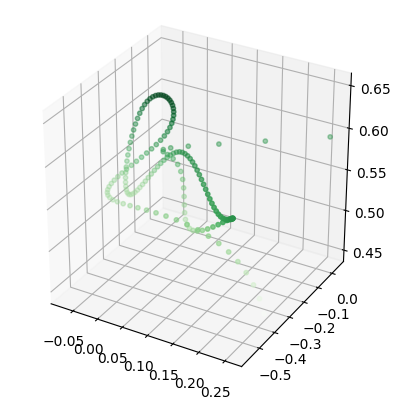

In [40]:
%matplotlib inline
with open('../output/demo.pkl', 'rb') as f:
    content = pickle.load(f)
ax = plt.axes(projection='3d')
x = content.traj[1]
y = content.traj[2]
z = content.traj[3]
ax.set_box_aspect((1, 1, 1))
# ax.plot3D(x, y, z, 'gray')

# Data for three-dimensional scattered points
ax.scatter3D(x,y,z, c=z, cmap='Greens', s=10)

p0 = np.loadtxt('../../bodypose3d/123/demo/kpts_cam0.dat')
p1 = np.loadtxt('../../bodypose3d/123/demo/kpts_cam1.dat')
cams = content.cameras

cam_kpts0 = []
cam_kpts1 = []
kpts_3d = []
for kp0, kp1 in zip(p0, p1):
    frame_kpts0 = []
    frame_kpts1 = []
    frame_kpts_3d = []
    for idx in range(0,len(kp0),2):
        frame_kpts0.append(kp0[idx:idx+2])
        frame_kpts1.append(kp1[idx:idx+2])
    for uv0, uv1 in zip(frame_kpts0, frame_kpts1):
        if uv0[0].any == -1 or uv1[0].any == -1:
            _p3d = [-1, -1, -1]
        else:
            _p3d = DLT(cams[0].P, cams[1].P, uv0, uv1) #calculate 3d position of keypoint
        frame_kpts_3d.append(_p3d)
    kpts_3d.append(frame_kpts_3d)
    cam_kpts0.append(frame_kpts0)
    cam_kpts1.append(frame_kpts1)

kpts_3d = np.array(kpts_3d)
write_keypoints_to_disk('../output/3dout.txt', kpts_3d)
(content.beta[1]-content.beta[0])

In [12]:
r0 =np.array([[0.03522596169240533, 0.9989186047045775, -0.030343908744683592 ],
[-0.9954114357284269, 0.0323669499742608, -0.09004695536460891 ],
[-0.08896743923434776, 0.03337666436934931, 0.9954751594247135 ]])
t0 = np.array([-3.7714497419971353, 
0.5952700116552851, 
14.753837487029038 ])
r1 = np.array([[0.01862128,  0.72598112,  0.68746248],
[-0.99830361, -0.02443645,  0.05284666],
[0.05516482, -0.68728034,  0.72429454]])
t1 = np.array([-8.97548292,
1.56690522,
22.88471505])

In [13]:
a = relativePosition(rotationMatrixToEulerAngles(content.cameras[0].R), content.cameras[0].t, rotationMatrixToEulerAngles(content.cameras[1].R), content.cameras[1].t)
a

(array([[ 1.58864064],
        [-0.19011831],
        [-1.58665964]]),
 array([[ 0.55139494],
        [ 0.77815892],
        [-0.01398622]]))

In [121]:
b  = relativePosition(rotationMatrixToEulerAngles(r0), t0, rotationMatrixToEulerAngles(r1), t1)
b

(array([[0.42017923],
        [0.58453008],
        [0.10871467]]),
 array([[-2.77787859],
        [ 8.1068915 ],
        [-4.54960514]]))

In [122]:
b/b[0][0][0]*a[0][0][0]

array([[[-0.15233198],
        [-0.21191581],
        [-0.03941347]],

       [[ 1.00709342],
        [-2.93907628],
        [ 1.649416  ]]])

In [22]:
content.cameras[0].R

array([[ 0.93329678,  0.35906638, -0.00533543],
       [-0.35624907,  0.92763994,  0.1121193 ],
       [ 0.04520763, -0.10273984,  0.99368043]])

In [23]:
content.cameras[1].R

array([[-0.08138642, -0.32805772,  0.94114525],
       [-0.4443046 ,  0.85720339,  0.2603762 ],
       [-0.89217133, -0.39696407, -0.21552227]])

In [17]:
kpts_3d.shape

(187, 12, 3)

In [144]:
def wc2cc(world_coordinate, R, T):
    # camera_coordinate = np.dot(R, (world_coordinate - T).T).T
    camera_coordinate = np.dot(R, world_coordinate.T).T + T
    return camera_coordinate

cam_kpts_3d = []
for frame in kpts_3d:
    cam_frame_kpt = []
    for joint in frame:
        cam_frame_kpt.append(wc2cc(joint, content.cameras[0].R, content.cameras[0].t))
    cam_kpts_3d.append(cam_frame_kpt)
    

In [145]:
cam_kpts_3d = np.array(cam_kpts_3d)

In [14]:
content.beta

array([-1.72381240e-02, -1.20020297e+02])

In [84]:
cam_kpts_3d

array([[[-0.38537247, -0.35208449,  2.19441152],
        [-0.51334044, -0.35950005,  2.2197015 ],
        [-0.38071973, -0.25040506,  2.20030982],
        ...,
        [-0.50532878, -0.01746851,  2.22714234],
        [-0.45884173,  0.11187412,  2.30548345],
        [-0.53111757,  0.10917735,  2.29875566]],

       [[-0.38540223, -0.35135615,  2.19445556],
        [-0.51294718, -0.35831476,  2.21811671],
        [-0.37969578, -0.2497908 ,  2.1944106 ],
        ...,
        [-0.50523394, -0.01818846,  2.22710637],
        [-0.45884173,  0.11187412,  2.30548345],
        [-0.52902622,  0.10968446,  2.29936532]],

       [[-0.38509135, -0.3503513 ,  2.19256171],
        [-0.51294718, -0.35831476,  2.21811671],
        [-0.38089196, -0.24847767,  2.19063558],
        ...,
        [-0.50523394, -0.01818846,  2.22710637],
        [-0.45874836,  0.11291995,  2.30576352],
        [-0.52759038,  0.10994771,  2.30172653]],

       ...,

       [[-0.4593031 , -0.36493761,  2.18333956],
        [-0

In [43]:
content.global_detections.shape

(3, 2722)

In [442]:
content.global_traj.shape

(7, 2080)

In [406]:
kpts_3d.shape

(1313, 12, 3)

In [264]:
(content.beta[0]-content.beta[1])/27*20

-0.3461288740615334

In [220]:
content.__dict__.keys()

dict_keys(['numCam', 'cameras', 'detections', 'detections_raw', 'detections_global', 'alpha', 'beta', 'beta_after_Fbeta', 'cf', 'traj', 'traj_len', 'sequence', 'visible', 'settings', 'gt', 'out', 'spline', 'rs', 'ref_cam', 'find_order', 'joint_id', 'frame_id_all', 'global_time_stamps_all', 'global_detections', 'global_traj'])

In [164]:
np.array(kpts_3d).shape

(187, 12, 3)

In [179]:
def wc2cc(world_coordinate, R, T):
    # camera_coordinate = np.dot(R, (world_coordinate - T).T).T
    nmsl =world_coordinate.T-T
    camera_coordinate = np.dot(R, nmsl.T).T # np.array([T]*len(world_coordinate))
    return camera_coordinate

def cc2ic(cc, cam_calib):
    f = cam_calib['fc']
    c = cam_calib['cc']
    joint_img = np.zeros(cc.shape)
    joint_img[:, 0], joint_img[:, 1], joint_img[:, 2] = __cam2pixel(cc, f, c)  # x,y
    joint_img[:, 2] = joint_img[:, 2]  # z
    return joint_img

def __cam2pixel(cc, f, c):
        u = cc[..., 0] / cc[..., 2] * f[0] + c[0]
        v = cc[..., 1] / cc[..., 2] * f[1] + c[1]
        d = cc[..., 2]
        return u, v, d

In [188]:
wc2cc(real_ext['cam1']['T'], real_ext['cam0']['R'], real_ext['cam0']['T'])

array([0.54054481, 4.47944224, 8.58950609])

In [190]:
wc2cc(content.cameras[1].t.T, content.cameras[0].R, content.cameras[0].t)

array([-0.01298741,  0.29483557,  0.69185522])

In [184]:
a = wc2cc(real, real_ext['cam0']['R'], real_ext['cam0']['T'])
a-a[0]

array([[  0.        ,   0.        ,   0.        ],
       [ -0.65546136,  -0.0639503 ,   1.40140932],
       [ -1.74162993,   0.09522295,   3.5608899 ],
       [ -2.12632815,   0.1992596 ,   4.07025562],
       [ -5.37625257,   0.66220013,   8.12656043],
       [ -3.69697896,  -0.27571619,   4.61090175],
       [ -6.89958183,   0.46441392,   9.03542077],
       [ -4.15654527,  -0.46596418,   5.0758284 ],
       [ -6.90171066,   0.34840086,   9.05368163],
       [ -7.00859936,   0.44688226,   9.08923162],
       [ -6.97268141,   0.41036671,   9.09380192],
       [ -7.1476836 ,   0.29073343,   9.00935818],
       [ -7.14900516,   0.33208332,   9.19049643],
       [ -7.25832395,   0.32634032,   9.34581388],
       [ -7.47927726,   0.27168854,   9.59967924],
       [ -8.11167277,   0.11628233,   9.9537411 ],
       [ -9.11523612,  -0.11066783,  10.62422831],
       [-10.11105903,  -0.22448518,  10.83539353],
       [-10.69626144,  -0.20577251,  11.3511119 ],
       [-10.90710902,  -0.23188

In [339]:
from reconstruction import epipolar as ep

In [355]:
d1 = np.array([[219.64069348, 218.85890605, 218.9034584,  218.89077705],
 [416.22102289, 416.18044477, 416.2290081,  416.06836092]])
d2 = np.array([[111.2451318,  111.2451318,  113.36337596, 114.4221577 ],
 [388.8006612,  388.8006612,  388.81882473, 388.82789625]])

In [358]:
def computeFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC, error=3, inliers=True):
    '''
    Function:
            compute fundamental matrix given correspondences (at least 8)
    Input:
            pts1, pts2 = list of pixel coordinates of corresponding features
            method = cv2.FM_RANSAC: Using RANSAC algorithm (default)
                     cv2.FM_LMEDS: Using least-median algorithm
                     cv2.FM_8POINT: Using 8 points algorithm
            error = reprojection threshold that describes maximal distance from a 
                    point to a epipolar line
            inlier = True: return F and the mask for inliers
                     False: only reture F
    Output:
            F = Fundamental matrix with size 3*3
            mask = index for inlier correspondences (optional)
    '''

    pts1 = pts1[:2].T
    pts2 = pts2[:2].T

    F, mask = cv2.findFundamentalMat(pts1,pts2,method,error)
    print(mask)
    if inliers and mask:
        return F, mask.reshape(-1,)
    else:
        return F

In [382]:
cv2.findFundamentalMat(d1[:2].T,d2[:2].T , cv2.FM_RANSAC, 100)

(None, None)

In [359]:
F,inlier = computeFundamentalMat(d1,d2,error=30)

None


TypeError: cannot unpack non-iterable NoneType object